# Seven Segment Text Extraction Using CNN

In [ ]:
!pip install git+https://github.com/faustomorales/keras-ocr.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-req-build-tkf_ab0p
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-req-build-tkf_ab0p
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.5 MB 43.8 MB/s 
     |████████████████████████████████| 619 kB 37.3 MB/s 
     |████████████████████████████████| 965 kB 62.0 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.0.0-py3-none-any.whl size=42306 sha256=995d53584521daba369d0cc0760cacc924a34186354be37213310560448f72ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-c4tispjg/wheels/70/f2/de/35bd7967fc8f67ea69d02593d61b40117bc7fed45b1a82a956
  Created wheel for validators: filename=validators-0.20.0-py3-none-a

In [ ]:
import random
import string
import math
import itertools
import os

import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

from matplotlib.pyplot import figure

#### Create Data

In [ ]:
!unzip "/content/ocr_training_data.zip" -d "/content/ocr_training_data"

Archive:  /content/ocr_training_data.zip
  inflating: /content/ocr_training_data/ocr_training_data/0072f880-397b-4c59-9bf7-d6f83c863ef8.png  
 extracting: /content/ocr_training_data/ocr_training_data/012a7ff5-76eb-4e55-870b-8c28e58e9d63.png  
  inflating: /content/ocr_training_data/ocr_training_data/0183531e-f05f-488b-afba-8a2e39729e91.png  
 extracting: /content/ocr_training_data/ocr_training_data/029b56a3-8d19-4376-aa8b-02a90367b307.png  
 extracting: /content/ocr_training_data/ocr_training_data/02a51083-81f2-43a7-87a3-7f74d4e89d47.png  
 extracting: /content/ocr_training_data/ocr_training_data/03acc103-023e-47c1-b774-46e25f60dc4a.png  
 extracting: /content/ocr_training_data/ocr_training_data/043edcfa-8038-40d9-b22d-99d1515b41bc.png  
 extracting: /content/ocr_training_data/ocr_training_data/04c7bf0e-583e-43d0-a989-41b6ddf78b28.png  
 extracting: /content/ocr_training_data/ocr_training_data/06818bdf-9ac9-4cb2-8e12-1374fd9628af.png  
 extracting: /content/ocr_training_data/ocr_traini

In [ ]:
data_dir = '/content/ocr_training_data/ocr_training_data'
gt_file = f'{data_dir}/gt.txt'

with open(gt_file) as file:
    lines = file.read().splitlines()
    train_labels = [(data_dir + '/' + line.split('\t')[0], None, line.split('\t')[1]) for line in lines]

In [ ]:
print(f'{train_labels} samples')

[('/content/ocr_training_data/ocr_training_data/6c5bec3e-68aa-4794-bff1-116e7db7ae0c.png', None, '009926'), ('/content/ocr_training_data/ocr_training_data/e316bb27-82fa-4382-920d-c69f2389d55a.png', None, '012240'), ('/content/ocr_training_data/ocr_training_data/6ae95c80-c0c5-4a1f-8826-07f4b93caa27.png', None, '000851'), ('/content/ocr_training_data/ocr_training_data/c8ee3e63-de17-4b67-bce2-ee7731696f0f.png', None, '24571'), ('/content/ocr_training_data/ocr_training_data/98ce7c68-fb7c-4601-8133-0fdacea3f9c1.png', None, '004824.0'), ('/content/ocr_training_data/ocr_training_data/4596bb11-3c38-42e5-bd11-59961bc223a9.png', None, '10735'), ('/content/ocr_training_data/ocr_training_data/043edcfa-8038-40d9-b22d-99d1515b41bc.png', None, '005693.3'), ('/content/ocr_training_data/ocr_training_data/7925f409-e735-45e1-a3d6-e2f160ba84e5.png', None, '102'), ('/content/ocr_training_data/ocr_training_data/23a7458a-0688-4320-bec9-ea8a21ddc8e4.png', None, '008360.3'), ('/content/ocr_training_data/ocr_tr

In [ ]:
alphabet = string.digits + string.ascii_lowercase + '.'
recognizer = keras_ocr.recognition.Recognizer(alphabet=alphabet)
recognizer.compile()
print(recognizer.model.input_shape)

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5
(None, 31, 200, 1)


We will resize the images to 200x31 to match the models input

In [ ]:
from PIL import Image
import os, sys

dirs = os.listdir(data_dir)
h, w = recognizer.model.input_shape[1], recognizer.model.input_shape[2]

def resize():
  for item in dirs:
    if os.path.isfile(data_dir+ '/' + item) and '.png' in item:
      im = Image.open(data_dir+ '/' + item)
      imResize = im.resize((w, h), Image.BICUBIC)
      imResize.save(data_dir + '/' + item, 'PNG')

resize()

In [ ]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

augmenter = iaa.Sequential(
    [sometimes(iaa.Affine(
            scale={"x": (0.1, 1.1), "y": (0.1, 1.1)},
            rotate=(-10, 10),
            shear=(-8, 8),
            order=[0, 1],
            cval=(0, 255),
            mode='constant'
        )),
        iaa.SomeOf((0, 3),
            [iaa.OneOf([
                    iaa.GaussianBlur((0, 1.0)),
                    iaa.AverageBlur(k=(1, 3)),
                    iaa.MedianBlur(k=(1, 3)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.25)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.5), direction=(0.0, 0.2)
                    ),
                ])),
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.03*255), per_channel=0.5
                ),
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),
                iaa.Invert(0.05, per_channel=True),
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.7, 1.2), per_channel=0.5),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),
                sometimes(iaa.JpegCompression(compression=(70, 99)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [ ]:
batch_size = 8

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

text: 1369.3
(31, 200, 3)


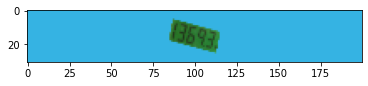

In [ ]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)
print(image.shape)


Now we can run training.

Epoch 1/30
31/31 [==============================] - 28s 221ms/step - loss: 22.3671 - val_loss: 14.7353
Epoch 2/30
31/31 [==============================] - 3s 107ms/step - loss: 15.6249 - val_loss: 14.2690
Epoch 3/30
31/31 [==============================] - 3s 107ms/step - loss: 14.5382 - val_loss: 16.2747
Epoch 4/30
31/31 [==============================] - 3s 107ms/step - loss: 12.6152 - val_loss: 8.1362
Epoch 5/30
31/31 [==============================] - 3s 106ms/step - loss: 10.3648 - val_loss: 5.9025
Epoch 6/30
31/31 [==============================] - 3s 107ms/step - loss: 8.7679 - val_loss: 5.7573
Epoch 7/30
31/31 [==============================] - 3s 106ms/step - loss: 8.2566 - val_loss: 3.9475
Epoch 8/30
31/31 [==============================] - 3s 106ms/step - loss: 7.3715 - val_loss: 7.9479
Epoch 9/30
31/31 [==============================] - 3s 108ms/step - loss: 7.2953 - val_loss: 2.7838
Epoch 10/30
31/31 [==============================] - 3s 109ms/step - loss: 7.1908 - val_los

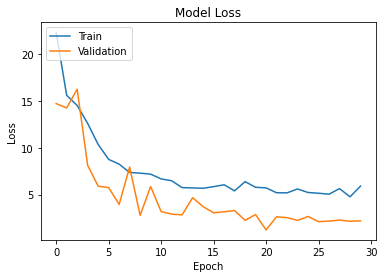

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('meeter_rec.h5', monitor='loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('meeter_rec.csv')
]

history = recognizer.training_model.fit(
    x=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=30,
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing

1/1 [==============================] - 0s 34ms/step
Predicted: 008087, Actual: 008087


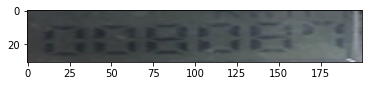

In [ ]:
import random as rnd
image_filepath, _, actual = validation_labels[rnd.randint(0, len(validation_labels))]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

1/1 [==============================] - 0s 31ms/step
Predicted: 1179.6


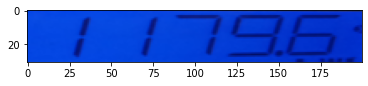

In [ ]:
import cv2
path = 'Test.png'
img = cv2.imread(path)
image_filepath = cv2.resize(img, (200, 31))
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [ ]:
with open('output.txt', 'w') as file:
    file.write(f'The extracted text is: ')
    file.write(predicted)
    file.close()